In [1]:


import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

from rubiks_cube import *
from rubiks_helpers import *
from rubiks_cube_states import *
from tqdm.notebook import tqdm, trange
from functools import lru_cache


In [2]:
# Solved Cube
cube = RubiksCube()
cube.draw()

         +--------+
         | y y y  |
         | y y y  |
         | y y y  |
+--------+--------+--------+--------+
| g g g  | o o o  | b b b  | r r r  |
| g g g  | o o o  | b b b  | r r r  |
| g g g  | o o o  | b b b  | r r r  |
+--------+--------+--------+--------+
         | w w w  |
         | w w w  |
         | w w w  |
         +--------+



In [3]:
# Rotate Faces
cube.rotate('F')
cube.rotate('R')
cube.draw()

         +--------+
         | y y o  |
         | y y o  |
         | g g o  |
+--------+--------+--------+--------+
| g g w  | o o b  | y y y  | g r r  |
| g g w  | o o w  | b b b  | y r r  |
| g g w  | o o w  | b b b  | y r r  |
+--------+--------+--------+--------+
         | b b r  |
         | w w r  |
         | w w r  |
         +--------+



In [4]:
# Rotate
cube.rotate('R F L r f l d')
cube.draw()

         +--------+
         | b y o  |
         | o y o  |
         | y b g  |
+--------+--------+--------+--------+
| o w r  | g w w  | o y y  | g r y  |
| g g b  | o o r  | b b b  | y r r  |
| r y w  | o g w  | b r r  | g g y  |
+--------+--------+--------+--------+
         | b o r  |
         | g w w  |
         | b w w  |
         +--------+



In [5]:
cube.shuffle()
cube.draw()

         +--------+
         | b g r  |
         | r y w  |
         | w y y  |
+--------+--------+--------+--------+
| r w g  | r g o  | b b y  | b r w  |
| o g o  | w o b  | y b o  | b r g  |
| o y o  | b b y  | o y y  | g w g  |
+--------+--------+--------+--------+
         | w r g  |
         | o w r  |
         | w g r  |
         +--------+



In [6]:
# real world randomly shuffled cube
input = \
''' gyr
    oyb
    yyr
ywo bgw gyb woo
ogg rob wby rrg
rww orr yrw goy
    bbg
    gww
    bbo
'''

cube.fromstring(input)
cube.draw()

         +--------+
         | g y r  |
         | o y b  |
         | y y r  |
+--------+--------+--------+--------+
| y w o  | b g w  | g y b  | w o o  |
| o g g  | r o b  | w b y  | r r g  |
| r w w  | o r r  | y r w  | g o y  |
+--------+--------+--------+--------+
         | b b g  |
         | g w w  |
         | b b o  |
         +--------+



## Cubes lösen

In [7]:
import torch
from torch import nn
import pickle

In [8]:
from net import Net as Net

#ep=3
#ep=13
#ep=22
ep=32
fn = f'data/rubik_ep{ep}_annealed.dat'
d = torch.load(fn)
print(f'Loading Network form path "{fn}"')
net = Net()
net.load_state_dict(d)
net.iter = 1000*ep+1
net_teacher = net

Loading Network form path "data/rubik_ep32_annealed.dat"


In [9]:
hashed_depth = -1
hashtable=dict()

class GetOutOfLoop(Exception):
    pass
    
def solve(state0, verbose=2, maxlen=100, batchsize=10, trials=100000):
    'maxlen: Maximal erlaubte Länge der Lösung'
    # batchsize von > 10 kann suboptimale sein und bringt keinen geschwindigkeitsvorteil(?)
    
    res = dict()
    
    def verb(*args):
        if verbose>=1: print(*args)
    
    @lru_cache(None)
    def penalty(l, t):
        #return log(l+1)*t*15 # return penalty dependent on parameter t
        #return 0.0*l*t # für kurze lösungen schneller
        return 0.8*l*t # für schnelleres finden allgemein
        
    def penalties(v, ms):
        l = len(ms)
        return [v + penalty(l, t) for t in np.arange(0, 1, 1/5)]
    
    try: state0 = oh2state(state0)
    except: pass
    
    v0 = net(np2t(state2oh(state0)[None,:]), policy=False).item()
    
    explored = set()
    queue = SolvingQueue(n=5)
    queue.push(item=(state0, v0, ''), values=5*[0])
    
    basestate0 = state0
    
    iter = 0
    
    try:
        
        while len(queue)>0:

            bsize = min(batchsize, len(queue)) # batch size is small at the beginning and can become bigger
            newstates = []
            ms = []

            for b in range(bsize):

                while True: # Take state out of queue that fulfills the maxlen constraint
                    if len(queue)==0:
                        verb(f'Aborting after {iter} trials due to empty queue!')
                        res['trials'] = iter
                        res['ms'] = -1
                        res['l'] = -1
                        return res
                    state0, v0, m0 = queue.pop(iter%5)
                    if len(m0) + 0.8*(v0-hashed_depth) - 0.5 < maxlen - hashed_depth: # erwartete lösungslänge vs. erlaubtes maximum
                        break

                verb(f'Iteration {iter}, Moves {m0} applied, Value = {v0}, len(queue) = {len(queue)}!')

                if iter%22==0 and b==0 and verbose>=2: draw(state0)
        
                s = state0.tobytes()
                if s in hashtable:
                    m0 += inverse_moves(mashtable[s])
                    verb(f'Cube is solved after {len(m0)} moves and {iter} trials!')
                    raise GetOutOfLoop
                    
                if issolved(state0):
                    verb(f'Cube is solved after {len(m0)} moves and {iter} trials!')
                    raise GetOutOfLoop
                    #print(f'Cube is solved after {len(m0)} moves and {iter} trials! Trying with a move less')
                    #maxlen -= 1
                    #continue

                # Auf jeden Würfel in xs die zwölf Züge anwenden und in zs speichern
                for m in moves:
                    newstates.append(apply(state0, m))
                    ms.append(m0+m)
                    
                iter += 1
                
                if iter >= trials:
                    verb(f'Aborting after {iter} trials')
                    res['trials'] = iter
                    res['ms'] = -1
                    res['l'] = -1
                    return res
                

            # Auf zs das Netzwerk anwenden und die Values in vs speichern (Vorhersage des Netzwerkes für den 'Wert' eines Status, d.h. wie nahe ein Status an dem gelösten Cube ist.)
            zs = np.array([ state2oh(s) for s in newstates ])
            with torch.no_grad():
                zs = np2t(zs)
                vsnext = net(zs, policy=False)
                vsnext  = t2np(vsnext[:,0])

            # Neue States der Queue hinzufügen
            for k in range(12*bsize):
                if newstates[k].tobytes() in explored:
                    continue
                else:
                    explored.add(newstates[k].tobytes())
                    queue.push(item=(newstates[k], vsnext[k], ms[k]), values=penalties(vsnext[k], ms[k]))
            
            
    except GetOutOfLoop:
        
        if verbose>=1:
            # print solving sequence of cubes
            cube = state2cube(basestate0)
            cube.draw()
            for m in m0:
                print(f'------------ Applying move {m} ------------')
                cube.rotate(m)
                cube.draw()
        if verbose>0:
            print(f'Cube is solved after {len(m0)} moves and {iter} trials!')

        res['ms'] = m0
        res['l'] = len(m0)
        res['trials'] = iter
        return res

In [11]:
# Lösen durch Breitensuche mit Heuristik durch Neuronales Netz (A-Stern)
# priority = (Anzahl Züge) * f + Abschätzung der noch auszuführenden Züge (durch neuronales Netz)
# f variiert zwischen f = 0 und f = 0.8

input = \
''' oor
    ryb
    ywo
byr grb yrb wgw
ogb wog rbw orb
wyr bog wyy owo
    yyr
    gwb
    ggg
'''

cube.fromstring(input)
cube.draw()
mystate = cube2state(cube)

solve(mystate, maxlen=30, trials=np.inf)

         +--------+
         | o o r  |
         | r y b  |
         | y w o  |
+--------+--------+--------+--------+
| b y r  | g r b  | y r b  | w g w  |
| o g b  | w o g  | r b w  | o r b  |
| w y r  | b o g  | w y y  | o w o  |
+--------+--------+--------+--------+
         | y y r  |
         | g w b  |
         | g g g  |
         +--------+

Iteration 0, Moves  applied, Value = 20.659406661987305, len(queue) = 0!
         +--------+
         | o o r  |
         | r y b  |
         | y w o  |
+--------+--------+--------+--------+
| b y r  | g r b  | y r b  | w g w  |
| o g b  | w o g  | r b w  | o r b  |
| w y r  | b o g  | w y y  | o w o  |
+--------+--------+--------+--------+
         | y y r  |
         | g w b  |
         | g g g  |
         +--------+

Iteration 1, Moves r applied, Value = 19.725887298583984, len(queue) = 11!
Iteration 2, Moves u applied, Value = 19.91814613342285, len(queue) = 10!
Iteration 3, Moves L applied, Value = 20.187158584594727, len(queue) = 9!
It

Iteration 86, Moves FLuFdfRFr applied, Value = 14.589138984680176, len(queue) = 757!
Iteration 87, Moves rFuLbDBLd applied, Value = 14.860673904418945, len(queue) = 756!
Iteration 88, Moves FLuFdfRFF applied, Value = 14.864171981811523, len(queue) = 755!
Iteration 89, Moves rFuRdF applied, Value = 16.458309173583984, len(queue) = 754!
Iteration 90, Moves FLuFdfRFb applied, Value = 14.8746337890625, len(queue) = 753!
Iteration 91, Moves rFuLbDBLuL applied, Value = 12.935294151306152, len(queue) = 855!
Iteration 92, Moves rFuLbDBLur applied, Value = 13.277473449707031, len(queue) = 854!
Iteration 93, Moves rFuLbFDFu applied, Value = 14.465675354003906, len(queue) = 853!
Iteration 94, Moves rFuLbU applied, Value = 16.468570709228516, len(queue) = 852!
Iteration 95, Moves rFuLbDBLuu applied, Value = 14.34461784362793, len(queue) = 851!
Iteration 96, Moves rFuLbDBLul applied, Value = 14.388742446899414, len(queue) = 850!
Iteration 97, Moves FLuFduLrd applied, Value = 14.628946304321289, len

Iteration 265, Moves rFuLbDBLurdLDfrbDRuurudB applied, Value = 7.626399040222168, len(queue) = 2409!
Iteration 266, Moves rFuLbDBLurdLDfrbRDuLf applied, Value = 7.646117687225342, len(queue) = 2408!
Iteration 267, Moves rFuLbDBLurdLDfrbRDuLF applied, Value = 7.664535045623779, len(queue) = 2407!
Iteration 268, Moves rFuLbDBLurdLDfrbRDufL applied, Value = 7.750300407409668, len(queue) = 2406!
Iteration 269, Moves rFuLd applied, Value = 17.31487274169922, len(queue) = 2405!
Iteration 270, Moves rFuLbDBLurdLDfrbDRuuruL applied, Value = 7.7958197593688965, len(queue) = 2402!
Iteration 271, Moves rFuLbDBLurdLDfrbDRuurudBr applied, Value = 7.037129878997803, len(queue) = 2504!
Iteration 272, Moves rFuLbDBLurdLDfrbRDufb applied, Value = 8.091392517089844, len(queue) = 2503!
Iteration 273, Moves rFuLbDBLurdLDfrU applied, Value = 10.359018325805664, len(queue) = 2502!
Iteration 274, Moves FLuFub applied, Value = 16.508764266967773, len(queue) = 2501!
Iteration 275, Moves rFuLbDBLurdLDfrbDRuurud

Iteration 449, Moves rFuRdrFu applied, Value = 15.417981147766113, len(queue) = 3924!
Iteration 450, Moves rFuLbDBLurdLDfrblRDLuull applied, Value = 7.78571891784668, len(queue) = 3914!
Iteration 451, Moves rFuLbDBLurdLDfrblRDLFLR applied, Value = 7.802409648895264, len(queue) = 4007!
Iteration 452, Moves rFuLbDBLurdLDfrblRDLDuR applied, Value = 7.803124904632568, len(queue) = 4006!
Iteration 453, Moves rFuLbDBLurdLDfrbldR applied, Value = 9.195467948913574, len(queue) = 4005!
Iteration 454, Moves rFuLRbUFF applied, Value = 14.594727516174316, len(queue) = 4004!
Iteration 455, Moves rFuLbDBLurdLDfrblRDLuulf applied, Value = 7.8772430419921875, len(queue) = 3988!
Iteration 456, Moves rFuLbDBLurdLDfrblRDLuuD applied, Value = 7.912607669830322, len(queue) = 3987!
Iteration 457, Moves rFuLbDBLurdLDfrblRDLuf applied, Value = 8.155153274536133, len(queue) = 3986!
Iteration 458, Moves rFuLbDBLurdLDfrblr applied, Value = 9.681360244750977, len(queue) = 3985!
Iteration 459, Moves rFuRdrFub appl

Iteration 630, Moves rFuLbDBLurdLDfrbDRuurfU applied, Value = 8.274983406066895, len(queue) = 5403!
Iteration 631, Moves rFuLbDBLurdLDfrbRDufbud applied, Value = 8.21435832977295, len(queue) = 5507!
Iteration 632, Moves rFuLbDBLurdLDfrbLBf applied, Value = 9.30450439453125, len(queue) = 5506!
Iteration 633, Moves rFuLbDBLurdLDfrfrr applied, Value = 9.869588851928711, len(queue) = 5505!
Iteration 634, Moves rFuLRbRflbd applied, Value = 13.638815879821777, len(queue) = 5504!
Iteration 635, Moves rFuLbDBLurdLDfrbDRuurdlF applied, Value = 8.276986122131348, len(queue) = 5503!
Iteration 636, Moves rFuLbDBLurdLDfrblRDLudB applied, Value = 8.284124374389648, len(queue) = 5502!
Iteration 637, Moves rFuLbDBLurdLDfrbRDuDf applied, Value = 8.724361419677734, len(queue) = 5501!
Iteration 638, Moves rFuLbDBLuLrDfdl applied, Value = 11.320647239685059, len(queue) = 5500!
Iteration 639, Moves FLuFduLu applied, Value = 15.560126304626465, len(queue) = 5499!
Iteration 640, Moves rFuLbDBLurdLDfrblRDLuRB

Iteration 818, Moves rFuLbDBLurdLDfrbbD applied, Value = 10.032508850097656, len(queue) = 6991!
Iteration 819, Moves rFuRFLRdd applied, Value = 14.979711532592773, len(queue) = 6990!
Iteration 820, Moves rFuLbDBLurdLDfrbDRuurdr applied, Value = 8.555449485778809, len(queue) = 6982!
Iteration 821, Moves rFuLbDBLurdLDfrblBfRL applied, Value = 8.079787254333496, len(queue) = 7085!
Iteration 822, Moves rFuLbDBLurdLDfrbRDuLu applied, Value = 8.929756164550781, len(queue) = 7084!
Iteration 823, Moves rFuLbDBLurdLDfrbfb applied, Value = 10.03702163696289, len(queue) = 7083!
Iteration 824, Moves rFuRFLRdfb applied, Value = 14.116519927978516, len(queue) = 7082!
Iteration 825, Moves rFuLbDBLurdLDfrbDRuurdrd applied, Value = 8.05037784576416, len(queue) = 7081!
Iteration 826, Moves rFuLbDBLurdLDfrbDRuurdru applied, Value = 8.263699531555176, len(queue) = 7080!
Iteration 827, Moves rFuLbDBLurdLDfrbRDF applied, Value = 9.574542999267578, len(queue) = 7079!
Iteration 828, Moves rFuLbDBLurdLDfrbdU a

{'ms': 'rFuLbDBLurdLDfrblRDLrDRuurdRld', 'l': 30, 'trials': 921}

## Wie lange braucht der Algorithmus zum Lösen

In [12]:
np.random.seed(0)
valbatch = []
for k in trange(640):
    state = shuffle(n=1000)
    valbatch.append(state2oh(state))
valbatch = np.array(valbatch)

  0%|          | 0/640 [00:00<?, ?it/s]

In [13]:
from time import time
print('starting')

T, L, tr = [], [], []
for i in range(640):
    t0 = time()
    res = solve(valbatch[i], maxlen=35, verbose=.1, batchsize=10)
    #res = solve_best(valbatch[i], maxlenstart=26)
    t1 = time()
    T.append(t1-t0)
    L.append(res['l'])
    tr.append(res['trials'])
    print(f'Solved in {t1-t0: .3f} s')
    if i%50 == 0:
        print(f'-- Cubes Number {i} --')
        print(f'-- Median of T is  {np.median(T): .03f} --')
        print(f'-- Mean   of T is  {np.mean(T): .03f} --')
        print(f'-- Max    of T is  {np.max(T): .03f} --')
        print(f'-- Median of L is  {np.median(L): .03f} --')
        print(f'-- Mean   of L is  {np.mean(L): .03f} --')
        print(f'-- Max    of L is  {np.max(L): .03f} --')
        print(f'-- Median of tr is {np.median(tr): } --')
        print(f'-- Mean   of tr is {np.mean(tr): .03f} --')
        print(f'-- Max    of tr is {np.max(tr)} --')
        print()

starting
Cube is solved after 28 moves and 1431 trials!
Solved in  1.238 s
-- Cubes Number 0 --
-- Median of T is   1.238 --
-- Mean   of T is   1.238 --
-- Max    of T is   1.238 --
-- Median of L is   28.000 --
-- Mean   of L is   28.000 --
-- Max    of L is   28.000 --
-- Median of tr is  1431.0 --
-- Mean   of tr is  1431.000 --
-- Max    of tr is 1431 --

Cube is solved after 28 moves and 9351 trials!
Solved in  7.822 s
Cube is solved after 28 moves and 391 trials!
Solved in  0.317 s
Cube is solved after 24 moves and 1311 trials!
Solved in  1.083 s
Cube is solved after 32 moves and 721 trials!
Solved in  0.593 s
Cube is solved after 32 moves and 341 trials!
Solved in  0.286 s
Cube is solved after 34 moves and 2471 trials!
Solved in  2.058 s
Cube is solved after 30 moves and 3771 trials!
Solved in  3.161 s
Cube is solved after 28 moves and 2441 trials!
Solved in  2.011 s
Cube is solved after 30 moves and 4411 trials!
Solved in  3.592 s
Cube is solved after 30 moves and 1031 trials!

KeyboardInterrupt: 

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


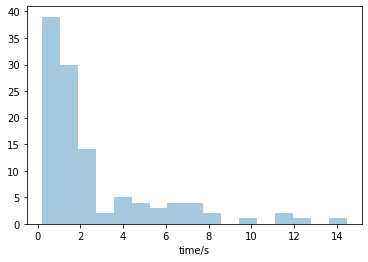

In [17]:
import seaborn as sns
sns.distplot(T, kde=False)
plt.xlabel('time/s');